<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Insurance Cross-Sell Opportunities

The client is an insurance company that has provided health insurance to its customers. Now they need your help to build a predictive model capable of predicting whether the insured individuals from the past year might be interested in purchasing vehicle insurance as well.

The dataset consists of the following properties:
- **id**: unique identifier of the buyer.
- **Gender**: gender of the buyer.
- **Age**: age of the buyer.
- **Driving_License**: 1 if the user has a driving license, 0 otherwise.
- **Region_Code**: unique code of the buyer's region.
- **Previously_Insured**: 1 if the user already has a vehicle insured, 0 otherwise.
- **Vehicle_Age**: age of the vehicle.
- **Vehicle_Damage**: 1 if the user has damaged the vehicle in the past, 0 otherwise.
- **Annual_Premium**: the amount the user has to pay as a premium during the year.
- **Policy_Sales_Channel**: anonymized code of the channel used for the proposal (e.g., email, phone, in person, etc.).
- **Vintage**: number of days the user has been a customer of the company.
- **Response**: 1 if the buyer responded positively to the sales proposal, 0 otherwise.

The goal of the model is to predict the value of **Response**.

[LINK TO THE DATASET (requires Kaggle account)](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1) import the dataset
df = pd.read_csv("insurance_cross_sell.csv")

In [26]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
# 2) RANDOM_SEED
RANDOM_SEED = 0

In [ ]:
# 3) 'id' feature has to be dropped, but first let's check that every observation is single, so 'id' carries no information
feature_name = 'id'
duplicates_presence = df[df.duplicated(subset=[feature_name], keep=False)]

if duplicates_presence.empty:
    print("All feature names are unique.")
else:
    print("Found repetitions.")

Tutti i nomi nella feature sono unici. Non ci sono ripetizioni.


In [ ]:
# 4) Unique presence confirmed, proceed to drop 'id'
df = df.drop("id", axis=1)

In [ ]:
# 5) next feature to manage is 'Vehicle_Age', to convert in binary dummies
df['Vehicle_Age'] = df['Vehicle_Age'].astype(str)
vehicle_age_dummies = pd.get_dummies(df['Vehicle_Age'], prefix='Vehicle_Age')
df = pd.concat([df, vehicle_age_dummies], axis=1)
df.drop('Vehicle_Age', axis=1, inplace=True)

In [ ]:
# 6) last features to manage are 'Gender' and 'Vehicle_Damage', both to convert in binaries
gender_dict = {"Female": 0, "Male": 1}
vedamage_dict = {"No":0, "Yes":1}
df['Gender'] = df['Gender'].map(lambda x: gender_dict[x])
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(lambda x: vedamage_dict[x])
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,1,44,1,28.0,0,1,40454.0,26.0,217,1,0,0,1
1,1,76,1,3.0,0,0,33536.0,26.0,183,0,1,0,0
2,1,47,1,28.0,0,1,38294.0,26.0,27,1,0,0,1
3,1,21,1,11.0,1,0,28619.0,152.0,203,0,0,1,0
4,0,29,1,41.0,1,0,27496.0,152.0,39,0,0,1,0


In [ ]:
# 7) check the feature 'Response' distribution
distri_response = df['Response'].value_counts()
print(distri_response)
print(f"Ratio: {distri_response[0]/distri_response[1]:.0f}:1")


0    334399
1     46710
Name: Response, dtype: int64
Ratio: 7:1


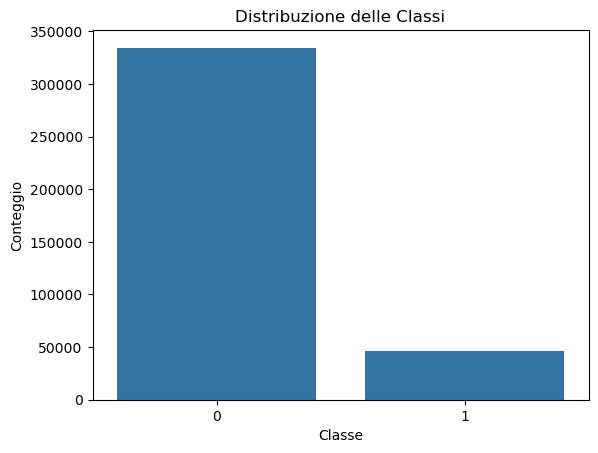

In [ ]:
# 7bis) Additional point univariate distribution graph
sns.countplot(x='Response', data=df)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# 7bis) ADDITIONAL POINT: collinearity study over multivariate distribution - data standardization
ss = StandardScaler()
df_standard = pd.DataFrame(ss.fit_transform(df), columns = df.columns)
df_standard.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,0.921545,0.333777,0.046208,0.121784,-0.919638,0.990294,0.574539,-1.587234,0.748795,2.675639,-1.052609,-0.872788,4.775866
1,0.921545,2.396751,0.046208,-1.767879,-0.919638,-1.009801,0.172636,-1.587234,0.342443,-0.373742,0.950021,-0.872788,-0.209386
2,0.921545,0.527181,0.046208,0.121784,-0.919638,0.990294,0.449053,-1.587234,-1.521998,2.675639,-1.052609,-0.872788,4.775866
3,0.921545,-1.148985,0.046208,-1.163187,1.087384,-1.009801,-0.113018,0.737321,0.581474,-0.373742,-1.052609,1.145754,-0.209386
4,-1.085134,-0.633242,0.046208,1.104409,1.087384,-1.009801,-0.178259,0.737321,-1.378580,-0.373742,-1.052609,1.145754,-0.209386


In [ ]:
#7bis) ADDITIONAL POINT: collinearity study over multivariate distribution - correlation
df_standard.corr()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
Gender,1.000000,0.145545,-0.018374,0.000604,-0.081932,0.091606,0.003673,-0.111159,-0.002517,0.052440,0.147633,-0.166280,0.043155
Age,0.145545,1.000000,-0.079782,0.042574,-0.254682,0.267534,0.067507,-0.577826,-0.001264,0.111147,0.692910,-0.787775,0.220694
Driving_License,-0.018374,-0.079782,1.000000,-0.001081,0.014969,-0.016622,-0.011906,0.043731,-0.000848,0.010155,-0.037403,0.040215,-0.006211
Region_Code,0.000604,0.042574,-0.001081,1.000000,-0.024659,0.028235,-0.010588,-0.042420,-0.002750,0.010570,0.038055,-0.044250,0.014555
Previously_Insured,-0.081932,-0.254682,0.014969,-0.024659,1.000000,-0.824143,0.004269,0.219381,0.002537,-0.341170,-0.279077,0.358773,-0.191352
Vehicle_Damage,0.091606,0.267534,-0.016622,0.028235,-0.824143,1.000000,0.009349,-0.224377,-0.002064,0.354400,0.284717,-0.370778,0.206961
Annual_Premium,0.003673,0.067507,-0.011906,-0.010588,0.004269,0.009349,1.000000,-0.113247,-0.000608,0.022575,-0.002495,-0.022555,0.061918
Policy_Sales_Channel,-0.111159,-0.577826,0.043731,-0.042420,0.219381,-0.224377,-0.113247,1.000000,0.000002,-0.139042,-0.508265,0.571516,-0.146238
Vintage,-0.002517,-0.001264,-0.000848,-0.002750,0.002537,-0.002064,-0.000608,0.000002,1.000000,-0.001050,-0.002632,0.002410,0.000600
Response,0.052440,0.111147,0.010155,0.010570,-0.341170,0.354400,0.022575,-0.139042,-0.001050,1.000000,0.164317,-0.209878,0.109300


<Axes: >

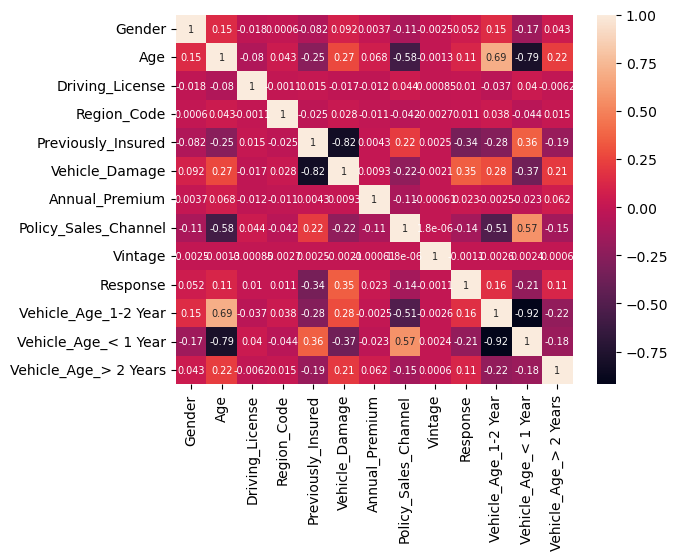

In [ ]:
# 7bis) ADDITIONAL POINT: collinearity study over multivariate distribution - heatmap correlation matrix
sns.heatmap(df_standard.corr(), annot=True, annot_kws={"size":7})

In [ ]:
#Comment: From the graph, we mainly notice two variables with an interesting correlation with Response, namely 
#Previously_Insured and Vehicle_Damage, but in both cases with values in the range of 0.3-0.4 in absolute terms.
#No particular collinearities are observed for the other variables either, considering that interesting values like 
#0.69 for Vehicle_Age are immediately contradicted by almost equal but opposite values (-0.79) in very similar classes, 
#which would be difficult to hypothesize if imagining a significant correlation.
#Lastly, the -0.82 correlation between Vehicle_Damage and Previously_Insured, meaning not having had vehicle damage (0) 
#while having other insurances (1), may concern cautious individuals and is thus a result of two parameters of definite 
#interest in the context of the reasoning given the study's objective.

In [ ]:
# 8) extract data from dataset
X = df.drop('Response', axis=1).values
y = df['Response'].values

In [ ]:
# 9) data division trian test 70-30%, adding stratify to keep constant proportions  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state = RANDOM_SEED)

In [ ]:
# 9bis) check class distribution
y_check = pd.Series(y)
y_train_check = pd.Series(y_train)
y_test_check = pd.Series(y_test)
print("Class Ratio - Original target")
print(y_check.value_counts(normalize=True))
print("Class Ratio - Train")
print(y_train_check.value_counts(normalize=True))
print("Class Ratio - Test")
print(y_test_check.value_counts(normalize=True))

Class Ratio - Original target
0    0.877437
1    0.122563
dtype: float64
Class Ratio - Train
0    0.877437
1    0.122563
dtype: float64
Class Ratio - Test
0    0.877437
1    0.122563
dtype: float64


In [ ]:
# 10) data standardization with same metrics both on X_train and X_test
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
# 11) since the problem refers to a binary classification, let's test a logistic regression model, keeping in mind the unbalance seen in 7)
logr = LogisticRegression(class_weight='balanced')
logr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
# 12) evaluate this forst model
y_pred_train = logr.predict(X_train)
y_pred_test = logr.predict(X_test)
print("Train report Logistic Regression - First Model")
print(classification_report(y_train, y_pred_train))
print('Test report Logistic Regression - First Model')
print(classification_report(y_test, y_pred_test))

Train report Logistic Regression - First Model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    234079
           1       0.25      0.97      0.40     32697

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Test report Logistic Regression - First Model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    100320
           1       0.25      0.97      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



In [ ]:
# 13) let's test another method, with additional correction
smote_tomek = SMOTETomek()
X_st_train, y_st_train = smote_tomek.fit_resample(X_train, y_train)

In [ ]:
# 14) fit on new train set
logr = LogisticRegression(class_weight="balanced")
logr.fit(X_st_train, y_st_train)

LogisticRegression(class_weight='balanced')

In [ ]:
# 15) evaluate this second model
y_pred_train = logr.predict(X_st_train)
y_pred_test = logr.predict(X_test)
print("Train report Logistic Regression - Second Model with SMOTE")
print(classification_report(y_st_train, y_pred_train))
print('Test report Logistic Regression - First Model')
print(classification_report(y_test, y_pred_test))

# this model shows improvement in ptarget response prediction, 
# losing 3 cents on negative precision, but gaining 46 on positives, and other 2 in recall on negatives 


# ADDITIONAL COMMENT: A special mention can be made regarding the tradeoff between model improvement and information loss.
# In this second model, the values of 0.71 in precision and 0.61 in recall are certainly improvable, so the model is far from optimal, 
# despite the cost paid in information loss due to the transition with SMOTETomek.
# However, I think that an improvement of more than 40% in precision is notable and perhaps enough to justify the cost of the loss. 
# In any case, both models are presented so that appropriate evaluations can be made.


Train report Logistic Regression - Second Model with SMOTE
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    229039
           1       0.71      0.97      0.82    229039

    accuracy                           0.79    458078
   macro avg       0.83      0.79      0.78    458078
weighted avg       0.83      0.79      0.78    458078

Test report Logistic Regression - First Model
              precision    recall  f1-score   support

           0       0.99      0.60      0.74    100320
           1       0.25      0.97      0.40     14013

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

